## Exploratory Analysis using Jupyter Notebook

Notebooks for exploratory analysis are standard in the industry. A Jupyter Notebook provides you a Python3 REPL and the ability to display charts and graphs in-line. GitHub also understands how to show .ipynb files correctly.

Pandas is another industry standard for data analysis. We can import it and use it to read data from our s3 bucket on AWS.

In [2]:
import pandas as pd

In [3]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)
s3.ls('twde-datalab/raw')

s3.get('twde-datalab/raw/quito_stores_sample2016-2017.csv', 
       '../data/quito_stores_sample2016-2017.csv')

#### Read from local csv file to a pandas DataFrame, an incredibly powerful object

In [4]:
data = pd.read_csv('../data/quito_stores_sample2016-2017.csv')

#### Before anything else, let's look at a small slice of the data to see what we're working with

In [5]:
data.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,cluster
0,88211471,2016-08-16,44,103520,7.0,True,Quito,Pichincha,5
1,88211472,2016-08-16,44,103665,7.0,False,Quito,Pichincha,5
2,88211473,2016-08-16,44,105574,13.0,False,Quito,Pichincha,5
3,88211474,2016-08-16,44,105575,18.0,False,Quito,Pichincha,5
4,88211475,2016-08-16,44,105577,8.0,False,Quito,Pichincha,5


#### With just this glimpse, you can start to fill out your list of assumptions, hypotheses, and questions. Some of mine are:
- Question: What is the span of dates we are provided?
- Question: How many distinct store_nbr values are there?
- Question: How many distinct item_nbr values are there?
- Hypothesis: unit_sales are always positive
- Hypothesis: onpromotion is always either True or False
- Hypothesis: city and state are always going to be Quito and Pichincha
- Hypothesis: cluster is always 5
- Question: What does cluster mean and is it important to know?
- Question: How many records does the data contain?
- Question: What other data files are available?

In [6]:
# Access an entire dataframe column like you would
# the value in a python dictionary:
# (The returned object has similar pandas built-in 
# functions, like 'head' and 'max')
print(data['date'].max())
print(data['date'].min())

2017-08-15
2016-08-16


In [7]:
# Dataframe columns also have a 'unique' method,
# which can answer several of our questions from above
data['store_nbr'].unique()

array([44, 45, 46, 47, 48, 49])

In [8]:
print(data['item_nbr'].unique())
print("There are too many item numbers to display, so let's just count them:")
print("There are {} different item_nbr values in our data"
          .format(len(data['item_nbr'].unique())))

[ 103520  103665  105574 ..., 2011468 2011448 2123839]
There are too many item numbers to display, so let's just count them:
There are 3717 different item_nbr values in our data


#### It might be helpful to know the 'shape' of our data. We could count by hand (for now) the columns, but how many rows do we have altogether?

In [9]:
print(data.shape)
print("There are {} rows and {} columns in our data".format(data.shape[0], data.shape[1]))

(5877318, 9)
There are 5877318 rows and 9 columns in our data


#### Moving along to answer our intial questions... Let's have a look at unit_sales. Keep in mind that unit sales is the variable we want to predict with our science.

Each row in our data is essentially telling us a `unit_sales` number for a given `item_nbr` at a given `store_nbr` on a given `date`. That is, "how many of an item was sold at a store on a day".

In [10]:
# the .describe() function often ends up using scientific notation,
# but we'll be fine just using 2 decimal places
pd.options.display.float_format = '{:,.2f}'.format

In [11]:
data.unit_sales.describe()

count   5,877,318.00
mean           13.85
std            30.87
min          -290.00
25%             3.00
50%             7.00
75%            14.00
max         6,932.00
Name: unit_sales, dtype: float64

### There are some strange things here.
My list of questions and assumptions is definitely changing given this description:

- Question: What does a negative sale mean?
  - (Answer: negative sales mean returns in this data)
- Question: How often are sales negative?
- Question: How many times are sales above 5,000?
- Question: How do the unit_sales numbers vary with the `date` column?


#### A good way to answer these questions is with some visualizations.

It might be difficult to get an intuitive feel of the data by knowing the exact answer to many of those questions. What we actually want to learn is the personality of the data. We want to know what it looks like in a glance.

### Let's import the python libraries that do the heavy lifting of data visualization

In [12]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns


and then let's look at a box plot of unit sales. A box plot conveys the mean and the middle 50% of the data, and things outside of that inter-quartile-range are generally considered outliers; errors in the data.

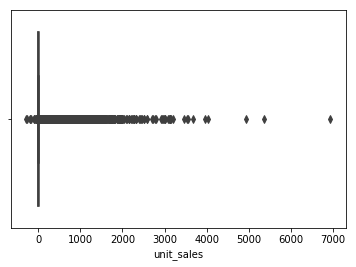

In [13]:
sns.boxplot(data.unit_sales)

This box plot is atrocious. We can't even recognize the inter-quartile-range. *I think it's reasonable to assume there aren't errors in the data, and that these "outliers" are real values. Or else Favorita would have a very big accounting issue to deal with.*

Let's look at the box plot again ignoring the sales of more than, say, 1000. We can make two new data frames and analyze them separately.

In [14]:
outliers = data[data.unit_sales > 1000]

In [15]:
majority_of_data = data[data.unit_sales <= 1000]

and once again look at the boxplot of the non-outlier (for lack of a better term) data

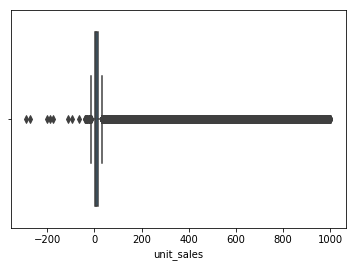

In [16]:
sns.boxplot(majority_of_data.unit_sales)

This is still really hard to see. Let's try a kernel density estimation plot. This will show us the probability of a data point being a certain value. We can see that the likelihood of getting a certain unit_sales value tapers off dramatically and has almost vanished by a unit_sales of 100.

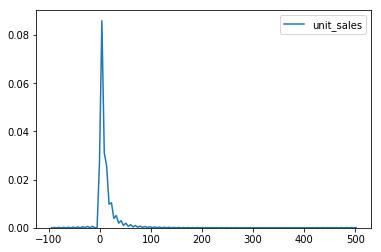

In [17]:
sns.kdeplot(majority_of_data.unit_sales, clip=[-100,500])

I'd also like to know how do sales change over time. Let's look at that with a scatter plot:

#### First, we convert the date column into a datetime object, and set it as the index
Then we find the weekly average of the data and plot it

In [48]:
data.index = pd.to_datetime(data.date)

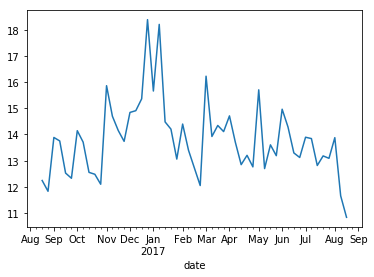

In [62]:
data.unit_sales.resample('W').mean().plot(x='index',y='unit_sales')

Here we can see the Christmas effect, where the weeks towards the end and beginning of the year see much more sales activity.


I'm curious to see if returns happen more frequently after Christmas, so I'm going to repeat the above plot, but only focusing on returns.

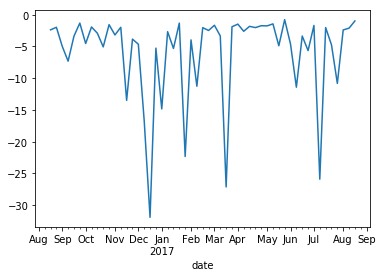

In [68]:
data[data.unit_sales < 0].unit_sales.resample('W').mean().plot(x='index',y='unit_sales')

This graph is surprising to me. Is it surprising to you? I still strongly suspect that returns happen at a statistically significantly different rate after Christmas, given that purchases spike around Dec-Jan anyway.  My next thought is about those outliers. Maybe `mean` isn't the right measurement to use, since means can be skewed by outliers. 

Let's see the same graph as above, only this time using `median` as the measurement. 

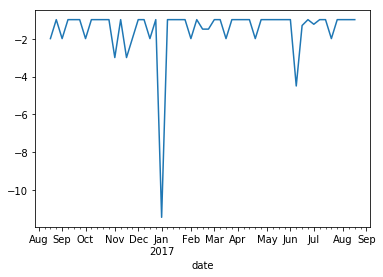

In [69]:
data[data.unit_sales < 0].unit_sales.resample('W').median().plot(x='index',y='unit_sales')

There we go. Look at that. When we use a statistic that is robust to outliers, we can see that return behavior is very different around Christmas. What we take away from this is: If we're to predict sales and returns for the end of December and beginning of January, our model should incorporate the effect of Christmas on sales. Perhaps it'd be useful to add columns called, `is_two_weeks_before_christmas` and `is_two_weeks_after_christmas`. 

I'm guessing about "two weeks" but maybe you, dear reader, would like to contribute an `.ipynb` file to this repository where you explore Christmas shopping behavior across all 4 years and tell us what features we should consider and why.

## An Abrupt Conclusion
I've walked you through a piece of the data exploration process. If I were to write this document again, it would go in a different direction. This is in many ways an art --- you will gain an intuition the more you do it. 

So, go do it. We want this `analysis` folder to be filled with notebooks showing exporatory analysis about different features and datasets. We expect to see evidence of exploratory analysis before incorporating new features and code into our algorithms. 